# MIDI music generation with GAN

In [4]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "maestro-v3.0.0"

--2025-08-18 13:54:15--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M  28.5MB/s    in 2.0s    

2025-08-18 13:54:17 (28.5 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]

Archive:  maestro-v3.0.0-midi.zip
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_T

In [1]:
!pip install miditok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:00


In [2]:
!pip install -q gdown

In [1]:
import os
import shutil
from pathlib import Path
import os
import numpy as np
from IPython.display import Audio, display
from miditok import REMI, TokenizerConfig
from pathlib import Path
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from random import shuffle
import json
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [5]:
destination_folder = "dataset_midi"
os.makedirs(destination_folder, exist_ok=True)

midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + \
             list(Path(dataset_path).resolve().glob("**/*.midi"))

print(f"Trovati {len(midi_paths)} file MIDI.")

for midi_path in midi_paths:
    filename = os.path.basename(midi_path)
    destination_path = os.path.join(destination_folder, filename)
    shutil.copy2(midi_path, destination_path)

print("Copia completata in 'dataset_midi'.")

# Convert to relative paths
midi_paths = [Path(os.path.join(destination_folder, os.path.basename(p))) for p in midi_paths]

Trovati 1276 file MIDI.
Copia completata in 'dataset_midi'.


## Tokenizzazione

Setup iniziale

In [ ]:
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": BEAT_RES,
    "num_velocities": 3,
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),
}

Carica file MIDI

In [ ]:
midi_dir = Path(destination_folder)
midis = list(midi_dir.glob("**/*.mid")) + list(midi_dir.glob("**/*.midi"))

if not midis:
    raise FileNotFoundError("Nessun file MIDI trovato in 'dataset_midi'.")

Train o carica il tokenizer

In [ ]:
config = TokenizerConfig(**TOKENIZER_PARAMS)

tokenizer = REMI(config)

vocab_size = 5000
tokenizer.train(vocab_size=vocab_size, files_paths=midis)
processed = [Path(f"{s}") for s in midis]
print(len(processed))

1276


In [ ]:
tokenizer.save("tokenizerMIDI")

Tokenizza i file MIDI

dataset preparation

In [ ]:
# Assicurati che la directory base sia un Path assoluto
base_dir = Path("/content/dataset_midi").resolve()

# Ottieni tutti i file MIDI come path assoluti
midis = list(base_dir.glob("**/*.mid")) + list(base_dir.glob("**/*.midi"))
midis = [midi.resolve() for midi in midis]

# Suddivisione in train/valid/test
total_num_files = len(midis)
num_files_valid = round(total_num_files * 0.15)
num_files_test = round(total_num_files * 0.15)

shuffle(midis)

midi_paths_valid = midis[:num_files_valid]
midi_paths_test = midis[num_files_valid:num_files_valid + num_files_test]
midi_paths_train = midis[num_files_valid + num_files_test:]

# Chunk e augment
for files_paths, subset_name in (
    (midi_paths_train, "train"),
    (midi_paths_valid, "valid")
):
    subset_chunks_dir = Path(f"Maestro_{subset_name}")

    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

    augment_dataset(
        subset_chunks_dir,
        pitch_offsets=[-12, 12],
        velocity_offsets=[-3, 3],
        duration_offsets=[-0.5, 0.5],
    )

# Rileggi i file MIDI già chunkati e augmentati per ciascun subset
midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
midi_paths_valid = list(Path("Maestro_valid").glob("**/*.mid")) + list(Path("Maestro_valid").glob("**/*.midi"))


Performing data augmentation: 100%|██████████| 1852/1852 [00:04<00:00, 406.03it/s]


tokenization

In [ ]:
def midi_valid(midi) -> bool:
    if any(ts.numerator != 4 for ts in midi.time_signature_changes):
        return False  # time signature different from 4/*, 4 beats per bar
    return True

if os.path.exists("tokenized"):
  shutil.rmtree("tokenized")

for dir in ("train", "valid"):
    tokenizer.tokenize_dataset(
        Path(f"Maestro_{dir}").resolve(),
        Path(f"tokenized_{dir}").resolve(),
        midi_valid,
    )

Tokenizing music files (content/tokenized_valid): 100%|██████████| 11162/11162 [04:41<00:00, 39.64it/s]


In [ ]:
!zip -r tokenized_train.zip tokenized_train
!zip -r tokenized_valid.zip tokenized_valid

Output streaming troncato alle ultime 5000 righe.
  adding: tokenized_valid/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_7#d240.json (deflated 70%)
  adding: tokenized_valid/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_04_Track04_wav_0#v3.json (deflated 63%)
  adding: tokenized_valid/MIDI-Unprocessed_Schubert1-3_MID--AUDIO_02_R2_2018_wav_2#p12.json (deflated 65%)
  adding: tokenized_valid/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4_5#p12.json (deflated 65%)
  adding: tokenized_valid/MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_01_WAV_4#v-3.json (deflated 64%)
  adding: tokenized_valid/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_04_Track04_wav_8#d-240.json (deflated 65%)
  adding: tokenized_valid/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--1_3#v-3.json (deflated 62%)
  adding: tokenized_valid/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1_4#p-12.

Scaricare tokenizer addestrato e midi

In [15]:
!gdown --id 1VfmfvXp8QiH10Q5VFTc_TCyKvGSthD3-
!gdown --id 1Cnj-YhsNcj_GTGTAwjgRsBwK8fXXKZax

!unzip tokenized_train.zip
!unzip tokenized_valid.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: tokenized_valid/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_7#d240.json  
  inflating: tokenized_valid/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_04_Track04_wav_0#v3.json  
  inflating: tokenized_valid/MIDI-Unprocessed_Schubert1-3_MID--AUDIO_02_R2_2018_wav_2#p12.json  
  inflating: tokenized_valid/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4_5#p12.json  
  inflating: tokenized_valid/MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_01_WAV_4#v-3.json  
  inflating: tokenized_valid/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_04_Track04_wav_8#d-240.json  
  inflating: tokenized_valid/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--1_3#v-3.json  
  inflating: tokenized_valid/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1_4#p-12.json  
  inflating: tokenized_valid/MIDI-Unprocessed_060_PIANO060_M

In [16]:
!gdown --id 12der1lMHfMyMbGWImONehL_43AoECyzB

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12der1lMHfMyMbGWImONehL_43AoECyzB
To: /content/tokenizer (2).json
100% 271k/271k [00:00<00:00, 127MB/s]


In [2]:
tokenizer = REMI(params="tokenizer (2).json")

In [3]:
def read_json(path: str) -> dict:
  with open(path, "r") as f:
    return json.load(f)

def read_json_files(json_file_paths):
    objects = []

    for file_path in tqdm(json_file_paths):
        try:
            objects.append(read_json(file_path))
        except FileNotFoundError:
            print(f"Error: File not found - {file_path}")
            return []
        except json.JSONDecodeError:
            print(f"Error decoding JSON in file: {file_path}")
            return []
    return objects

tokenized_train = list(Path("tokenized_train").resolve().glob("**/*.json"))
data_objects_train = read_json_files(tokenized_train)

tokenized_valid = list(Path("tokenized_valid").resolve().glob("**/*.json"))
data_objects_valid = read_json_files(tokenized_valid)



if data_objects_train and data_objects_valid:
    print(f"\nSuccessfully read {len(data_objects_train)} training JSON files.")
    print(f"Successfully read {len(data_objects_valid)} validation JSON files.")
else:
    print("Error reading JSON files.")

100%|██████████| 11162/11162 [00:01<00:00, 7479.90it/s]


Successfully read 51073 training JSON files.
Successfully read 11162 validation JSON files.


In [4]:
encoded_train = [np.array(song["ids"][0]) for song in data_objects_train]
encoded_valid = [np.array(song["ids"][0]) for song in data_objects_valid]
all_ids_train = np.concatenate(encoded_train)
all_ids_valid = np.concatenate(encoded_valid)

all_ids_train = all_ids_train.astype(dtype=np.int32)
all_ids_valid = all_ids_valid.astype(dtype=np.int32)

## GAN model

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        # Livelli fully-connected
        self.input_layer = nn.Linear(noise_dim, hidden_dim * 8)
        self.hidden_layer1 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.hidden_layer2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.hidden_layer3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_length)

        # Attivazioni e dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.input_layer(noise_vector))
        x = self.dropout(self.relu(self.hidden_layer1(x)))
        x = self.dropout(self.relu(self.hidden_layer2(x)))
        x = self.dropout(self.relu(self.hidden_layer3(x)))
        x = self.output_layer(x)
        return torch.tanh(x)

In [33]:
class Generator(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        # Livelli fully-connected
        self.input_layer = nn.Linear(noise_dim, hidden_dim * 16)
        self.hidden_layer1 = nn.Linear(hidden_dim * 16, hidden_dim * 8)
        self.hidden_layer2 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.hidden_layer3 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.hidden_layer4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_length)

        # Attivazioni e dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.input_layer(noise_vector))
        x = self.dropout(self.relu(self.hidden_layer1(x)))
        x = self.dropout(self.relu(self.hidden_layer2(x)))
        x = self.dropout(self.relu(self.hidden_layer3(x)))
        x = self.dropout(self.relu(self.hidden_layer4(x)))
        x = self.output_layer(x)
        return torch.tanh(x)

In [46]:
class Generator(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        # Livelli fully-connected
        self.input_layer = nn.Linear(noise_dim, hidden_dim * 32)
        self.hidden_layer1 = nn.Linear(hidden_dim * 32, hidden_dim * 16)
        self.hidden_layer2 = nn.Linear(hidden_dim * 16, hidden_dim * 8)
        self.hidden_layer3 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.hidden_layer4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.hidden_layer5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_length)

        # Attivazioni e dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.input_layer(noise_vector))
        x = self.dropout(self.relu(self.hidden_layer1(x)))
        x = self.dropout(self.relu(self.hidden_layer2(x)))
        x = self.dropout(self.relu(self.hidden_layer3(x)))
        x = self.dropout(self.relu(self.hidden_layer4(x)))
        x = self.dropout(self.relu(self.hidden_layer5(x)))
        x = self.output_layer(x)
        return torch.tanh(x)

Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        # Livelli fully-connected
        self.input_layer = nn.Linear(input_length, hidden_dim * 2)
        self.hidden_layer1 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.hidden_layer2 = nn.Linear(hidden_dim * 4, hidden_dim * 8)
        self.output_layer = nn.Linear(hidden_dim * 8, 1)

        # Attivazioni e dropout
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        x = self.leaky_relu(self.input_layer(sequence))
        x = self.dropout(self.leaky_relu(self.hidden_layer1(x)))
        x = self.dropout(self.leaky_relu(self.hidden_layer2(x)))
        x = self.output_layer(x)
        return x

In [34]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        # Livelli fully-connected
        self.input_layer = nn.Linear(input_length, hidden_dim * 2)
        self.hidden_layer1 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.hidden_layer2 = nn.Linear(hidden_dim * 4, hidden_dim * 8)
        self.hidden_layer3 = nn.Linear(hidden_dim * 8, hidden_dim * 16)
        self.output_layer = nn.Linear(hidden_dim * 16, 1)

        # Attivazioni e dropout
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        x = self.leaky_relu(self.input_layer(sequence))
        x = self.dropout(self.leaky_relu(self.hidden_layer1(x)))
        x = self.dropout(self.leaky_relu(self.hidden_layer2(x)))
        x = self.dropout(self.leaky_relu(self.hidden_layer3(x)))
        x = self.output_layer(x)
        return x

In [47]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        # Livelli fully-connected
        self.input_layer = nn.Linear(input_length, hidden_dim * 2)
        self.hidden_layer1 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.hidden_layer2 = nn.Linear(hidden_dim * 4, hidden_dim * 8)
        self.hidden_layer3 = nn.Linear(hidden_dim * 8, hidden_dim * 16)
        self.hidden_layer4 = nn.Linear(hidden_dim * 26, hidden_dim * 32)
        self.output_layer = nn.Linear(hidden_dim * 32, 1)

        # Attivazioni e dropout
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        x = self.leaky_relu(self.input_layer(sequence))
        x = self.dropout(self.leaky_relu(self.hidden_layer1(x)))
        x = self.dropout(self.leaky_relu(self.hidden_layer2(x)))
        x = self.dropout(self.leaky_relu(self.hidden_layer3(x)))
        x = self.dropout(self.leaky_relu(self.hidden_layer4(x)))
        x = self.output_layer(x)
        return x

In [7]:
vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
hidden_dim = 1536
batch_size = 128

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : hidden_dim,
    "output_length" : seq_length
}


discriminator_config = {
    "input_length" : seq_length,
    "hidden_dim" : hidden_dim
}

generator = Generator(**generator_config)
discriminator = Discriminator(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}

GAN

In [8]:
class GAN:
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        noise_dim: int,
        sequence_length: int,
        tokenizer,
        loss_fn: nn.Module = nn.BCEWithLogitsLoss(),
    ):
        """
        Classe GAN per addestrare un generatore e discriminatore.
        """
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = noise_dim
        self.sequence_length = sequence_length
        self.loss_fn = loss_fn
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        # Ottimizzatori
        self.generator_optimizer = torch.optim.Adam(
            self.generator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )
        self.discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )

        # Inizializzazione pesi
        self.generator.apply(self._init_weights)
        self.discriminator.apply(self._init_weights)

    def _init_weights(self, layer):
        """Inizializza i pesi dei layer lineari e conv1d."""
        if isinstance(layer, (nn.Linear, nn.Conv1d)):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def _sample_noise(self, batch_size: int, device: torch.device) -> torch.Tensor:
        """Genera rumore casuale come input per il generatore."""
        return torch.randn(batch_size, self.noise_dim, device=device)

    def _generator_train_step(self, batch_size: int, device: torch.device) -> float:
        """Esegue un passo di training per il generatore."""
        self.generator.zero_grad()

        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)
        fake_predictions = self.discriminator(fake_data)

        loss_g = -torch.mean(fake_predictions)

        if not (torch.isnan(loss_g) or torch.isinf(loss_g)):
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
            self.generator_optimizer.step()
        else:
            print("⚠ NaN o Inf rilevato nella loss del generatore.")

        return loss_g.item()

    def _discriminator_train_step(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device
    ) -> float:
        """Esegue un passo di training per il discriminatore."""
        self.discriminator.zero_grad()

        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)

        real_predictions = self.discriminator(real_data)
        fake_predictions = self.discriminator(fake_data)

        real_labels = torch.ones_like(real_predictions)
        fake_labels = torch.zeros_like(fake_predictions)

        loss_real = self.loss_fn(real_predictions, real_labels)
        loss_fake = self.loss_fn(fake_predictions, fake_labels)

        loss_d = loss_real + loss_fake

        if not (torch.isnan(loss_d) or torch.isinf(loss_d)):
            loss_d.backward()
            self.discriminator_optimizer.step()
        else:
            print("⚠ NaN o Inf rilevato nella loss del discriminatore.")

        return loss_d.item()

    def _train_batch(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device,
        generator_steps: int, discriminator_steps: int
    ):
        """Esegue un batch di training alternando generator e discriminator."""
        discriminator_losses = [
            self._discriminator_train_step(batch_size, real_data, device)
            for _ in range(discriminator_steps)
        ]
        generator_losses = [
            self._generator_train_step(batch_size, device)
            for _ in range(generator_steps)
        ]
        return np.mean(discriminator_losses), np.mean(generator_losses)

    def train(
        self,
        dataloader,
        epochs: int,
        device: torch.device,
        loss_delta: float = 0.7,
        steps_each_print: int = 5,
        advantage_steps: int = 2,
        alternate_training: bool = False,
        generator_steps: int = 1,
        discriminator_steps: int = 1,
    ):
        """
        Addestra la GAN su un dataloader.
        """
        print(f"🚀 Avvio training per {epochs} epoche")
        self.generator.to(device).train()
        self.discriminator.to(device).train()

        all_d_losses = []
        all_g_losses = []

        for epoch in range(epochs):
            pbar = tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")
            for step, real_batch in enumerate(dataloader):
                batch_size = real_batch.size(0)
                real_batch = real_batch.to(device)

                d_loss, g_loss = self._train_batch(
                    batch_size, real_batch, device, generator_steps, discriminator_steps
                )
                all_d_losses.append(d_loss)
                all_g_losses.append(g_loss)

                if alternate_training:
                    if g_loss - d_loss > loss_delta:
                        generator_steps, discriminator_steps = advantage_steps, 1
                    elif d_loss - g_loss > loss_delta:
                        discriminator_steps, generator_steps = advantage_steps, 1
                    else:
                        generator_steps, discriminator_steps = 1, 1

                if (step + 1) % steps_each_print == 0:
                    desc = f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
                    if generator_steps != 1 or discriminator_steps != 1:
                        desc += f" | D Steps: {discriminator_steps}, G Steps: {generator_steps}"
                    pbar.set_description(desc)
                pbar.update(1)

            pbar.close()
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

        return all_d_losses, all_g_losses

    def save_generator(self, filepath: str):
        """Salva il generatore su disco."""
        torch.save(self.generator.state_dict(), filepath)

    def save_discriminator(self, filepath: str):
        """Salva i pesi del discriminatore su disco."""
        torch.save(self.discriminator.state_dict(), filepath)

    def predict(self, n_samples: int, device: torch.device):
        """Genera output dal generatore sotto forma di array NumPy."""
        noise = self._sample_noise(n_samples, device)
        return self.generator(noise).cpu().detach().numpy()

    def generate_midi(self, n_samples: int, output_prefix: str, device: torch.device):
        """Genera e salva file MIDI a partire dal generatore."""
        predictions = self.predict(n_samples, device)
        midpoint = self.vocab_size // 2
        predictions = [x * midpoint + midpoint for x in predictions]

        for i, pred in enumerate(predictions):
            pred_tokens = pred.astype(np.int32)
            pred_tokens[pred_tokens == self.vocab_size] = 0
            try:
                decoded = self.tokenizer.decode([pred_tokens])
                decoded.dump_midi(f"{output_prefix}_{i}.mid")
            except Exception as e:
                print(f"Errore nella generazione MIDI: {e}")


In [9]:
class TokenDataset(Dataset):
    """Dataset di sequenze di token normalizzate per addestramento GAN."""
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)


def normalize_data(token_array, vocab_size: int, interval=(-1, 1)):
    """
    Normalizza i dati di input in un intervallo specificato.
    Default: (-1, 1)
    """
    min_val, max_val = interval
    normalized = (token_array - vocab_size / 2) / (vocab_size / 2)
    scaled = normalized * (max_val - min_val) / 2 + (max_val + min_val) / 2
    return scaled


# ===============================
# PARAMETRI
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length  # preso dalla configurazione generale
batch_size = batch_size       # manteniamo il valore esistente

# ===============================
# PREPARAZIONE DATI
# ===============================
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

# Creiamo sequenze della lunghezza richiesta
sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

# Dataset e DataLoader
dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

# Test rapido GPU
_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")


Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 786


In [10]:
gan = GAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan.train(**training_arguments)

🚀 Avvio training per 45 epoche


D Loss: 1.2472, G Loss: 0.8710: 100%|██████████| 786/786 [02:21<00:00,  5.56it/s]


Epoch 1/45 | D Loss: 1.3487 | G Loss: 1.0118


D Loss: 0.4205, G Loss: 2.5626: 100%|██████████| 786/786 [02:22<00:00,  5.53it/s]


Epoch 2/45 | D Loss: 0.4307 | G Loss: 3.2548


D Loss: 0.0651, G Loss: 5.6401: 100%|██████████| 786/786 [02:21<00:00,  5.56it/s]


Epoch 3/45 | D Loss: 0.0489 | G Loss: 4.7916


D Loss: 0.0484, G Loss: 7.9902: 100%|██████████| 786/786 [02:21<00:00,  5.57it/s]


Epoch 4/45 | D Loss: 0.0379 | G Loss: 6.9563


D Loss: 1.4960, G Loss: -0.2479: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 5/45 | D Loss: 1.4921 | G Loss: -0.2065


D Loss: 1.4103, G Loss: -0.0419: 100%|██████████| 786/786 [02:19<00:00,  5.65it/s]


Epoch 6/45 | D Loss: 1.4133 | G Loss: 0.0523


D Loss: 1.2101, G Loss: 1.2535: 100%|██████████| 786/786 [02:18<00:00,  5.66it/s]


Epoch 7/45 | D Loss: 0.8855 | G Loss: 3.0091


D Loss: 0.2115, G Loss: 4.3803: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 8/45 | D Loss: 0.2477 | G Loss: 4.3267


D Loss: 0.0268, G Loss: 7.1627: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 9/45 | D Loss: 0.0282 | G Loss: 6.9098


D Loss: 1.4229, G Loss: 0.1824: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 10/45 | D Loss: 1.4599 | G Loss: 0.0900


D Loss: 0.3259, G Loss: 3.4391: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 11/45 | D Loss: 0.2433 | G Loss: 4.1860


D Loss: 0.2730, G Loss: 2.9322: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 12/45 | D Loss: 0.4276 | G Loss: 2.7778


D Loss: 0.8794, G Loss: 8.8729: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 13/45 | D Loss: 0.2985 | G Loss: 4.7054


D Loss: 0.4118, G Loss: 6.3051: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 14/45 | D Loss: 0.2930 | G Loss: 5.7658


D Loss: 0.7184, G Loss: 2.6183: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 15/45 | D Loss: 0.5329 | G Loss: 5.2798


D Loss: 0.7366, G Loss: 2.0884: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 16/45 | D Loss: 0.8130 | G Loss: 2.3482


D Loss: 0.8582, G Loss: 3.4338: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 17/45 | D Loss: 0.7017 | G Loss: 2.7646


D Loss: 0.9527, G Loss: 7.5842: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 18/45 | D Loss: 0.5661 | G Loss: 5.9572


D Loss: 1.1320, G Loss: 5.6535: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 19/45 | D Loss: 0.9964 | G Loss: 2.5506


D Loss: 1.9968, G Loss: 0.8680: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 20/45 | D Loss: 1.1509 | G Loss: 4.3812


D Loss: 0.8022, G Loss: 2.5781: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 21/45 | D Loss: 0.7300 | G Loss: 2.5875


D Loss: 1.2583, G Loss: 4.1176: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 22/45 | D Loss: 0.8116 | G Loss: 3.7329


D Loss: 0.8862, G Loss: 2.2650: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 23/45 | D Loss: 0.8058 | G Loss: 4.6514


D Loss: 0.8606, G Loss: 3.0957: 100%|██████████| 786/786 [02:20<00:00,  5.61it/s]


Epoch 24/45 | D Loss: 1.0488 | G Loss: -0.2286


D Loss: 1.0950, G Loss: 1.4219: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 25/45 | D Loss: 1.0045 | G Loss: 2.3129


D Loss: 0.8917, G Loss: 2.7387: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 26/45 | D Loss: 1.0205 | G Loss: 2.6900


D Loss: 0.7837, G Loss: 1.6465: 100%|██████████| 786/786 [02:19<00:00,  5.62it/s]


Epoch 27/45 | D Loss: 0.9191 | G Loss: 1.9281


D Loss: 0.8586, G Loss: 2.1217: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 28/45 | D Loss: 0.9850 | G Loss: 2.8931


D Loss: 1.4827, G Loss: 0.9110: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 29/45 | D Loss: 1.1029 | G Loss: 2.3011


D Loss: 1.5475, G Loss: -0.5992: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 30/45 | D Loss: 1.2314 | G Loss: 1.0843


D Loss: 1.0578, G Loss: 1.8789: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 31/45 | D Loss: 1.0546 | G Loss: 1.9078


D Loss: 1.0569, G Loss: 1.3062: 100%|██████████| 786/786 [02:19<00:00,  5.63it/s]


Epoch 32/45 | D Loss: 1.0249 | G Loss: 1.6255


D Loss: 0.9774, G Loss: 1.2248: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 33/45 | D Loss: 1.3752 | G Loss: 0.8504


D Loss: 1.0524, G Loss: 1.9979: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 34/45 | D Loss: 1.2300 | G Loss: 1.3275


D Loss: 1.2537, G Loss: 0.8811: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 35/45 | D Loss: 1.3053 | G Loss: 0.2530


D Loss: 1.1514, G Loss: 0.9620: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 36/45 | D Loss: 0.9477 | G Loss: 1.4508


D Loss: 1.1880, G Loss: 0.2233: 100%|██████████| 786/786 [02:19<00:00,  5.65it/s]


Epoch 37/45 | D Loss: 1.1944 | G Loss: 0.7263


D Loss: 1.3617, G Loss: -0.2736: 100%|██████████| 786/786 [02:19<00:00,  5.65it/s]


Epoch 38/45 | D Loss: 1.1180 | G Loss: 0.7436


D Loss: 1.2310, G Loss: 1.0515: 100%|██████████| 786/786 [02:19<00:00,  5.65it/s]


Epoch 39/45 | D Loss: 1.1848 | G Loss: 2.1274


D Loss: 1.1639, G Loss: 0.4664: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 40/45 | D Loss: 1.1395 | G Loss: 1.4741


D Loss: 1.3531, G Loss: 0.5296: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 41/45 | D Loss: 1.3465 | G Loss: 0.4242


D Loss: 1.3715, G Loss: 0.8099: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 42/45 | D Loss: 1.2053 | G Loss: 0.8861


D Loss: 1.2587, G Loss: 0.3388: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]


Epoch 43/45 | D Loss: 1.3369 | G Loss: 0.4679


D Loss: 1.3492, G Loss: 0.2433: 100%|██████████| 786/786 [02:19<00:00,  5.65it/s]


Epoch 44/45 | D Loss: 1.3785 | G Loss: 0.3683


D Loss: 1.5018, G Loss: 0.6974: 100%|██████████| 786/786 [02:19<00:00,  5.64it/s]

Epoch 45/45 | D Loss: 1.2823 | G Loss: 0.4568


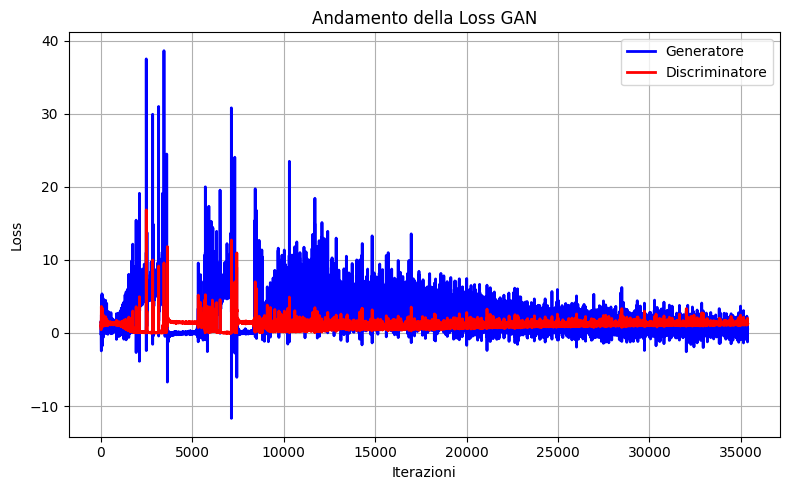

In [11]:
import matplotlib.pyplot as plt

# Plot

iterations = list(range(1, len(losses_discriminator) + 1))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generatore", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminatore", color="red", linewidth=2)

plt.xlabel("Iterazioni")
plt.ylabel("Loss")
plt.title("Andamento della Loss GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

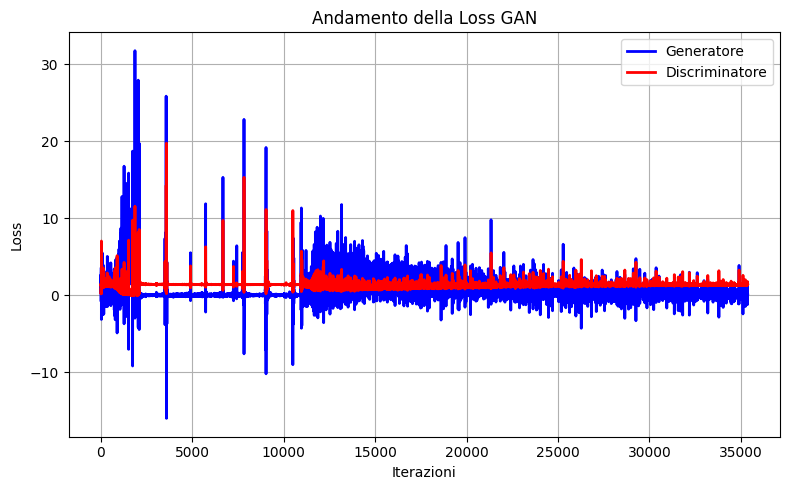

In [ ]:
import matplotlib.pyplot as plt

# Plot

iterations = list(range(1, len(losses_discriminator) + 1))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generatore", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminatore", color="red", linewidth=2)

plt.xlabel("Iterazioni")
plt.ylabel("Loss")
plt.title("Andamento della Loss GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

salva il modello

In [12]:
# Salva solo i pesi del generator e del discriminator
torch.save(generator.state_dict(), "generator_weights.pth")
torch.save(discriminator.state_dict(), "discriminator_weights.pth")


per caricare

In [ ]:
generator = Generator(**generator_config)
generator.load_state_dict(torch.load("generator_weights.pth"))
generator.eval()

discriminator = Discriminator(**discriminator_config)
discriminator.load_state_dict(torch.load("discriminator_weights.pth"))
discriminator.eval()


generate music

In [13]:
noise_dim = 512  # Dimensione del vettore di rumore

def generate_noise(batch_size: int, device: torch.device) -> torch.Tensor:
    """Genera un batch di rumore casuale per il generatore."""
    return torch.randn(batch_size, noise_dim, device=device)

def predict_sequences(generator: torch.nn.Module, n_samples: int, device: torch.device):
    """Genera sequenze normalizzate dal generatore."""
    noise_batch = generate_noise(n_samples, device)
    return generator(noise_batch).cpu().detach().numpy()

def generate_midi_files(generator: torch.nn.Module, n_samples: int, output_prefix: str, device: torch.device):
    """
    Genera file MIDI a partire da output del generatore.
    """
    # Genera sequenze normalizzate
    normalized_outputs = predict_sequences(generator, n_samples, device)

    # Calcolo del boundary per mappare valori normalizzati ai token originali
    boundary = len(tokenizer) // 2
    token_sequences = [output * boundary + boundary for output in normalized_outputs]

    for i, sequence in enumerate(token_sequences):
        tokens = sequence.astype(np.int32)

        # Rimpiazza eventuali valori fuori vocabolario
        tokens[tokens == len(tokenizer)] = 0

        try:
            decoded_midi = tokenizer.decode([tokens])
            file_path = f"{output_prefix}_{i}.mid"
            decoded_midi.dump_midi(file_path)
            print(f"MIDI generato: {file_path}")
        except Exception as e:
            print(f"Errore nella generazione MIDI per il sample {i}: {e}")


In [14]:

num_midi_files = 100

output_folder = "generated"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

sample_normalized_outputs = predict_sequences(generator, 2, device)
token_boundary = len(tokenizer) // 2
sample_token_sequences = [seq * token_boundary + token_boundary for seq in sample_normalized_outputs]

generate_midi_files(
    generator=generator,
    n_samples=num_midi_files,
    output_prefix=output_prefix,
    device=device,
)


MIDI generato: generated/generated_midi_0.mid
MIDI generato: generated/generated_midi_1.mid
MIDI generato: generated/generated_midi_2.mid
MIDI generato: generated/generated_midi_3.mid
MIDI generato: generated/generated_midi_4.mid
MIDI generato: generated/generated_midi_5.mid
MIDI generato: generated/generated_midi_6.mid
MIDI generato: generated/generated_midi_7.mid
MIDI generato: generated/generated_midi_8.mid
MIDI generato: generated/generated_midi_9.mid
MIDI generato: generated/generated_midi_10.mid
MIDI generato: generated/generated_midi_11.mid
MIDI generato: generated/generated_midi_12.mid
MIDI generato: generated/generated_midi_13.mid
MIDI generato: generated/generated_midi_14.mid
MIDI generato: generated/generated_midi_15.mid
MIDI generato: generated/generated_midi_16.mid
MIDI generato: generated/generated_midi_17.mid
MIDI generato: generated/generated_midi_18.mid
MIDI generato: generated/generated_midi_19.mid
MIDI generato: generated/generated_midi_20.mid
MIDI generato: generate

In [15]:
!zip -r generetedMIDI.zip generated

updating: generated/ (stored 0%)
updating: generated/generated_midi_83.mid (deflated 37%)
updating: generated/generated_midi_95.mid (deflated 38%)
updating: generated/generated_midi_35.mid (deflated 37%)
updating: generated/generated_midi_7.mid (deflated 40%)
updating: generated/generated_midi_57.mid (deflated 39%)
updating: generated/generated_midi_84.mid (deflated 40%)
updating: generated/generated_midi_22.mid (deflated 37%)
updating: generated/generated_midi_47.mid (deflated 38%)
updating: generated/generated_midi_2.mid (deflated 39%)
updating: generated/generated_midi_53.mid (deflated 38%)
updating: generated/generated_midi_63.mid (deflated 39%)
updating: generated/generated_midi_66.mid (deflated 38%)
updating: generated/generated_midi_73.mid (deflated 40%)
updating: generated/generated_midi_91.mid (deflated 40%)
updating: generated/generated_midi_6.mid (deflated 38%)
updating: generated/generated_midi_75.mid (deflated 39%)
updating: generated/generated_midi_4.mid (deflated 36%)
up

VALUTARE prestazioni

In [6]:
!gdown --id 1t9BCZUrk_Io0ayouCly-KPLmjSGy5bBP

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1t9BCZUrk_Io0ayouCly-KPLmjSGy5bBP
To: /content/generetedMIDI.zip
100% 133k/133k [00:00<00:00, 112MB/s]


In [7]:
!unzip generetedMIDI.zip

Archive:  generetedMIDI.zip
   creating: generated/
  inflating: generated/generated_midi_83.mid  
  inflating: generated/generated_midi_95.mid  
  inflating: generated/generated_midi_35.mid  
  inflating: generated/generated_midi_7.mid  
  inflating: generated/generated_midi_57.mid  
  inflating: generated/generated_midi_84.mid  
  inflating: generated/generated_midi_22.mid  
  inflating: generated/generated_midi_47.mid  
  inflating: generated/generated_midi_2.mid  
  inflating: generated/generated_midi_53.mid  
  inflating: generated/generated_midi_63.mid  
  inflating: generated/generated_midi_66.mid  
  inflating: generated/generated_midi_73.mid  
  inflating: generated/generated_midi_91.mid  
  inflating: generated/generated_midi_6.mid  
  inflating: generated/generated_midi_75.mid  
  inflating: generated/generated_midi_4.mid  
  inflating: generated/generated_midi_59.mid  
  inflating: generated/generated_midi_90.mid  
  inflating: generated/generated_midi_88.mid  
  inflating:

In [8]:
import glob

In [10]:
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00


In [11]:
import mido
import numpy as np
from collections import Counter

# --- Funzioni originali ---
def pitch_count(notes):
    """
    notes: list of int (pitch values)
    """
    return len(notes)


def note_density(notes, total_duration_sec):
    """
    notes: list of notes
    total_duration_sec: duration of piece in seconds
    """
    return len(notes) / total_duration_sec if total_duration_sec > 0 else 0

def rote_memorization_frequency(notes, pattern_length=3):
    """
    Return average number of repetitions for note patterns of length `pattern_length`
    """
    patterns = [tuple(notes[i:i+pattern_length]) for i in range(len(notes)-pattern_length+1)]
    counts = Counter(patterns)
    repeated = [count for pattern, count in counts.items() if count > 1]
    return np.mean(repeated) if repeated else 0

def pitch_intervals(notes):
    """
    Returns average absolute pitch interval between consecutive notes
    """
    if len(notes) < 2:
        return 0
    intervals = [abs(notes[i] - notes[i-1]) for i in range(1, len(notes))]
    return np.mean(intervals)

def pitch_class_histogram(notes):
    """
    Returns normalized histogram over 12 pitch classes
    """
    hist = np.zeros(12)
    for pitch in notes:
        hist[pitch % 12] += 1
    total = np.sum(hist)
    return hist / total if total > 0 else hist


# --- Funzione per estrarre le note da un file MIDI ---
def extract_notes_from_midi(file_path):
    mid = mido.MidiFile(file_path)
    notes = []
    total_time = 0.0

    for track in mid.tracks:
        time_accum = 0
        for msg in track:
            time_accum += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)  # pitch MIDI
        total_time = max(total_time, time_accum * mid.ticks_per_beat)

    # Calcolo durata in secondi
    duration_sec = mid.length
    return notes, duration_sec


# --- WRAPPER FUNZIONI ---
def pitch_count_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_count(notes)

def note_density_from_midi(file_path):
    notes, duration_sec = extract_notes_from_midi(file_path)
    return note_density(notes, duration_sec)

def rote_memorization_frequency_from_midi(file_path, pattern_length=3):
    notes, _ = extract_notes_from_midi(file_path)
    return rote_memorization_frequency(notes, pattern_length)

def pitch_intervals_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_intervals(notes)

def pitch_class_histogram_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_class_histogram(notes)


In [12]:
import os
import numpy as np

# --- Wrapper generale ---
def run_function_on_folder(folder_path, func):
    """
    Esegue una funzione (wrapper MIDI) su tutti i file MIDI in una cartella.

    Parameters:
        folder_path (str): percorso della cartella con i MIDI
        func (callable): funzione wrapper che accetta un file_path

    Returns:
        np.ndarray: risultati per ogni file MIDI
    """
    results = []
    midi_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".mid", ".midi"))]

    for fname in midi_files:
        file_path = os.path.join(folder_path, fname)
        try:
            result = func(file_path)
            results.append(result)
        except Exception as e:
            print(f"Errore con {fname}: {e}")
            results.append(None)

    return np.array(results, dtype=object)


In [13]:
import os
import numpy as np
from scipy.special import rel_entr

# ---- Funzione KLD ----
def kld(p, q):
    """
    Kullback-Leibler Divergence between distributions p and q
    p, q: numpy arrays representing probability distributions
    """
    p = np.asarray(p, dtype=np.float64) + 1e-12  # evitare log(0)
    q = np.asarray(q, dtype=np.float64) + 1e-12
    p /= p.sum()
    q /= q.sum()
    return np.sum(rel_entr(p, q))


# ---- Wrapper per creare distribuzioni ----
def make_distribution(values, bins=50, range=None):
    """
    Trasforma una lista di valori numerici in una distribuzione normalizzata
    """
    hist, _ = np.histogram(values, bins=bins, range=range, density=False)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist


# ---- Confronto indicatori tra 2 cartelle ----
def compare_folders_with_kld(real_folder, generated_folder):
    results = {}

    # Pitch count
    real_pc = run_function_on_folder(real_folder, pitch_count_from_midi)
    gen_pc  = run_function_on_folder(generated_folder, pitch_count_from_midi)
    results["pitch_count"] = kld(make_distribution(real_pc), make_distribution(gen_pc))

    # Note density
    real_nd = run_function_on_folder(real_folder, note_density_from_midi)
    gen_nd  = run_function_on_folder(generated_folder, note_density_from_midi)
    results["note_density"] = kld(make_distribution(real_nd), make_distribution(gen_nd))

    # Rote memorization frequency
    real_rm = run_function_on_folder(real_folder, rote_memorization_frequency_from_midi)
    gen_rm  = run_function_on_folder(generated_folder, rote_memorization_frequency_from_midi)
    results["rote_memorization_frequency"] = kld(make_distribution(real_rm), make_distribution(gen_rm))

    # Pitch intervals
    real_pi = run_function_on_folder(real_folder, pitch_intervals_from_midi)
    gen_pi  = run_function_on_folder(generated_folder, pitch_intervals_from_midi)
    results["pitch_intervals"] = kld(make_distribution(real_pi), make_distribution(gen_pi))

    # Pitch class histogram (media su tutti i file)
    real_hist = np.mean(run_function_on_folder(real_folder, pitch_class_histogram_from_midi), axis=0)
    gen_hist  = np.mean(run_function_on_folder(generated_folder, pitch_class_histogram_from_midi), axis=0)
    results["pitch_class_histogram"] = kld(real_hist, gen_hist)

    return results


In [14]:
generated_folder = "/content/generated"
real_folder = "/content/dataset_midi"

results = compare_folders_with_kld(real_folder, generated_folder)

for key, value in results.items():
    print(f"{key}: KLD = {value:.4f}")


pitch_count: KLD = 11.4217
note_density: KLD = 1.8555
rote_memorization_frequency: KLD = 24.6687
pitch_intervals: KLD = 2.2066
pitch_class_histogram: KLD = 0.0004
